In [1]:
from import_data_utils import *
from AlexNet_keras_model import model
from scipy.stats import ttest_ind as ttest

2023-11-15 12:28:54.403593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 12:28:54.403913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 12:28:54.404188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 12:28:54.404456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 12:28:54.427730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "Alex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 57, 57, 96)        34944     
_________________________________________________________________
norm1 (Lambda)               (None, 57, 57, 96)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 256)       307456    
_________________________________________________________________
norm2 (Lambda)               (None, 28, 28, 256)       0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)       885120 

In [2]:
def one_side_t_test(x,y):
    t_stat, p_val = ttest(y,x,equal_var = False)
    one_sided_p_val = p_val / 2
    # For a test where you expect group1 to have a smaller mean than group2
    if t_stat < 0:
        one_sided_p_val = 1 - one_sided_p_val
    return one_sided_p_val
        

In [3]:
#VGG


with open('/home/mor/NDS_project/results_data/sub2/Vgg/FF/results_202304241138/corr_dict_vis_all.pkl', 'rb') as f:
    corr_dict_vis_all_vgg = pkl.load(f)
    
with open('/home/mor/NDS_project/results_data/sub2/Vgg/DRC/results_DRC_202304241349/corr_dict_vis_all.pkl', 'rb') as f:
    corr_dict_vis_all_drc = pkl.load(f)

In [4]:
np.mean(corr_dict_vis_all_drc[0]['V1v'][:,8])

0.11384788885508927

No handles with labels found to put in legend.


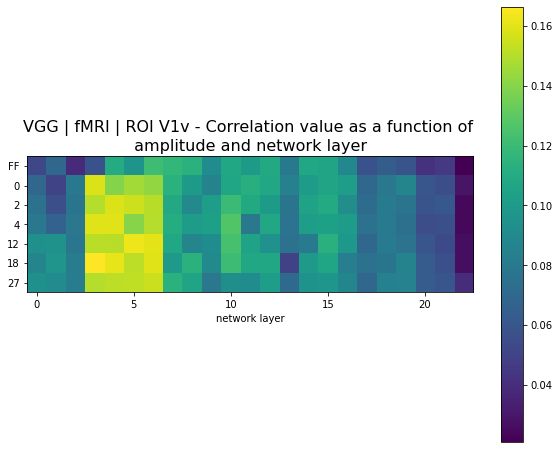

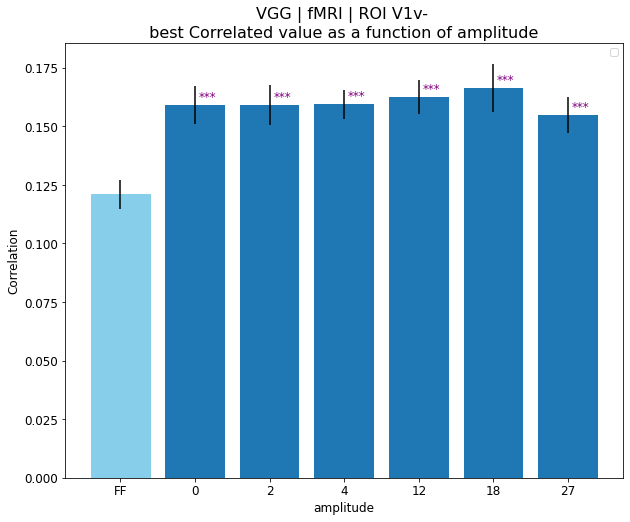

No handles with labels found to put in legend.


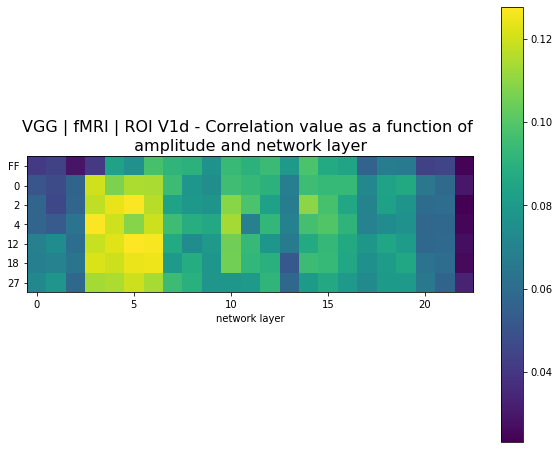

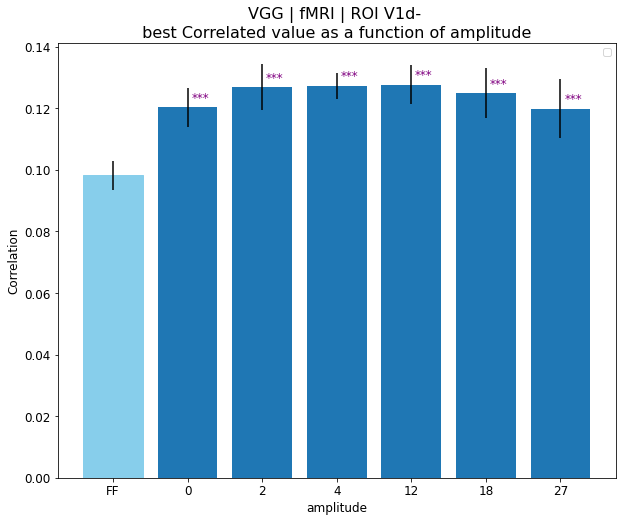

No handles with labels found to put in legend.


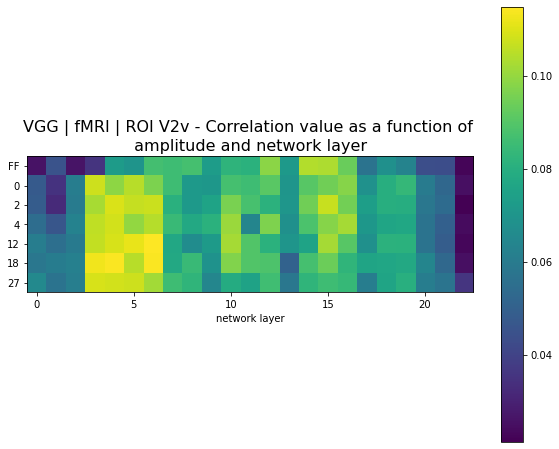

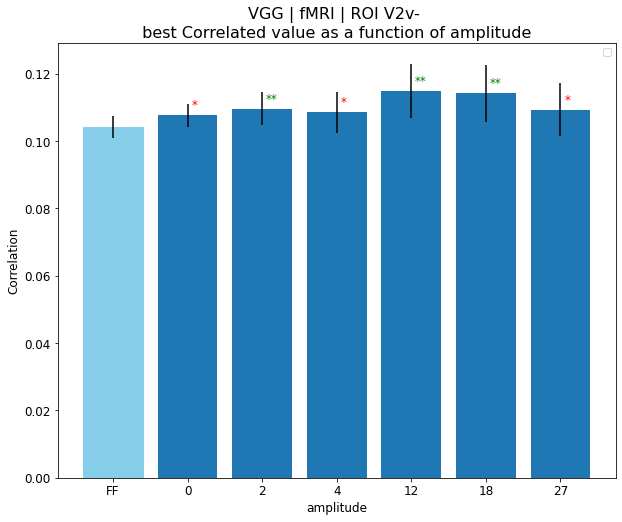

No handles with labels found to put in legend.


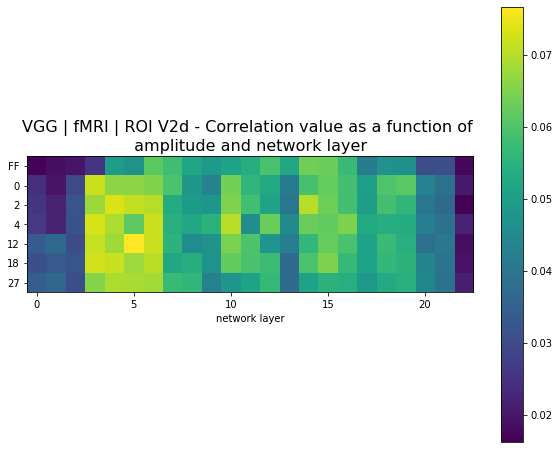

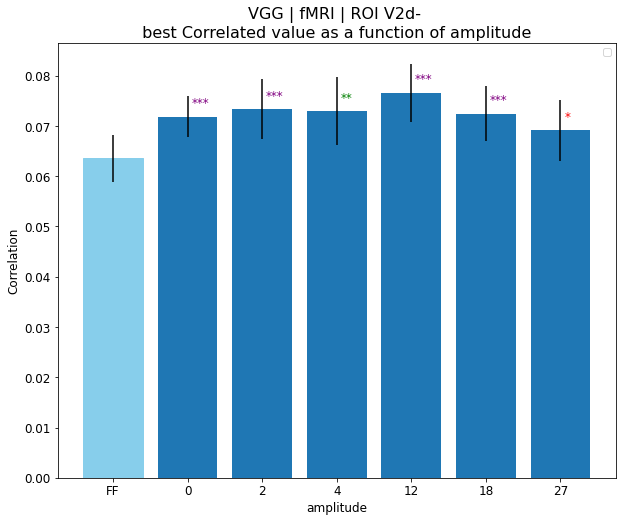

No handles with labels found to put in legend.


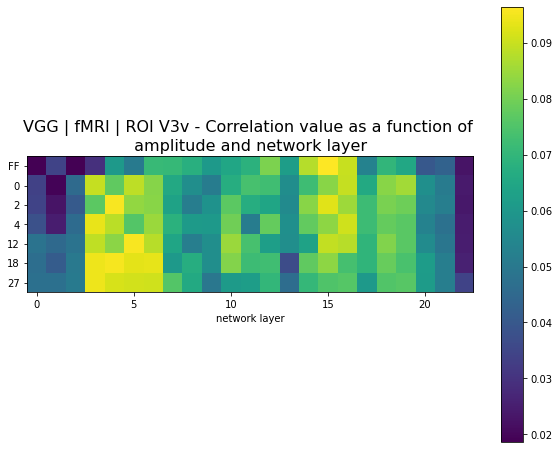

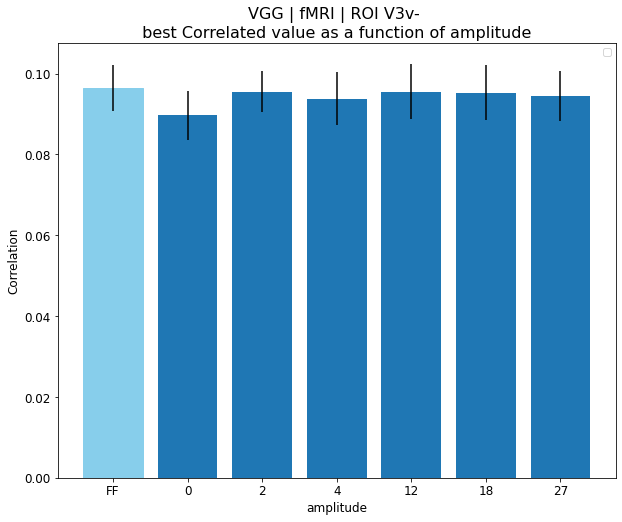

No handles with labels found to put in legend.


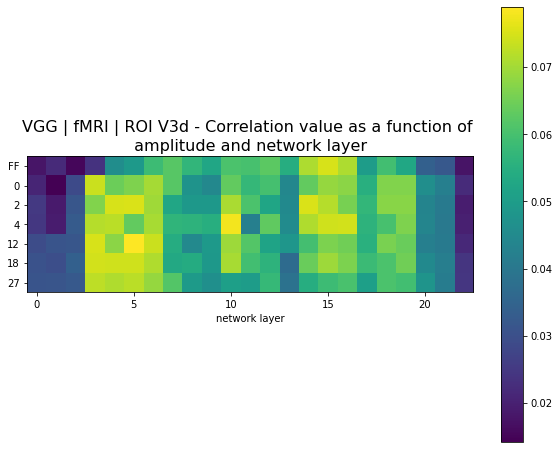

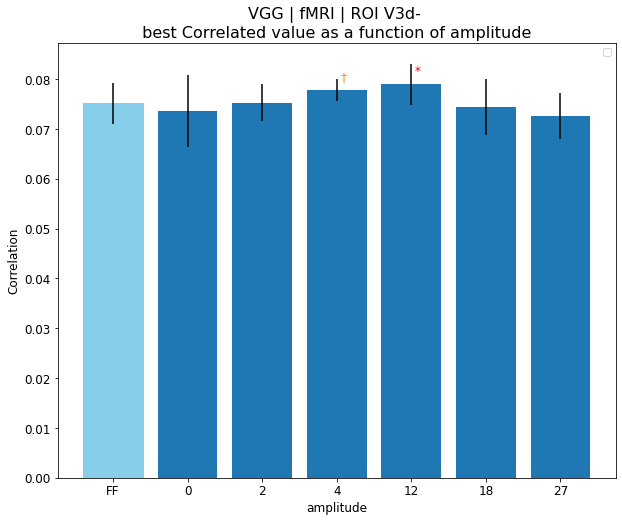

No handles with labels found to put in legend.


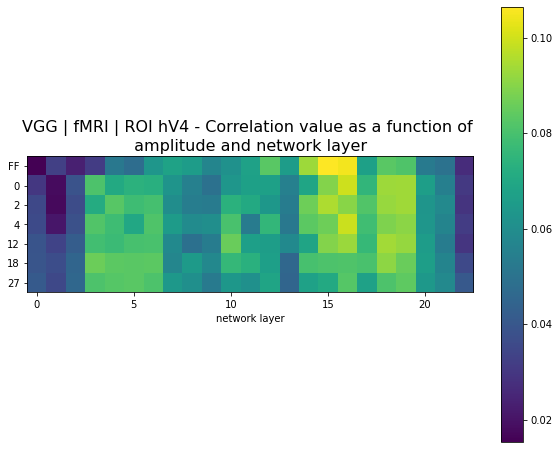

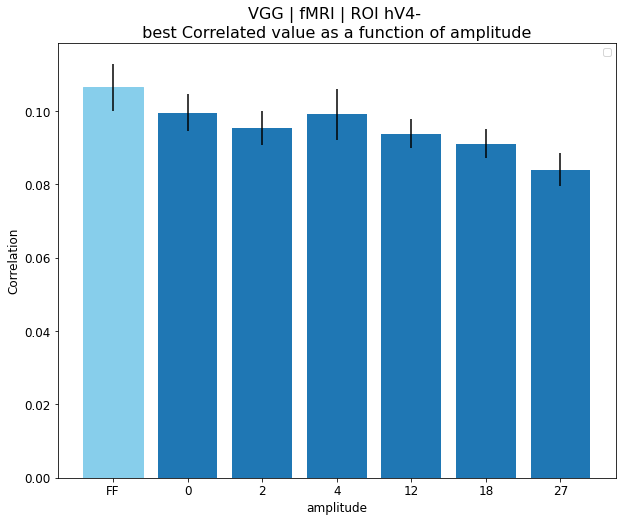

In [5]:
gap = 1
amplist = [str(amp) for amp in corr_dict_vis_all_drc.keys()]
amplist.insert(0,'FF')
alpha = 0.05  # significance level
alpha_1 = 0.01

for key in corr_dict_vis_all_vgg.keys():
    cor = np.zeros([len(list(corr_dict_vis_all_drc.keys())) + 1, corr_dict_vis_all_vgg[key].shape[1]]) # (ff+all amps) * network layers
    sd = np.zeros_like(cor)
    cor[0] = np.mean(corr_dict_vis_all_vgg[key], axis=0) # mean over all resamples for each layer FF
    sd[0] = np.std(corr_dict_vis_all_vgg[key], axis=0) # sd over all resamples for each layer FF
    for i, amp in enumerate(corr_dict_vis_all_drc.keys()):
        cor[i+1] = np.mean(corr_dict_vis_all_drc[amp][key][:,gap:], axis=0) # DRC - mean over all resamples for each layer
        sd[i+1] = np.std(corr_dict_vis_all_drc[amp][key][:,gap:], axis=0) # DRC -sd over all resamples for each layer

    plt.figure(figsize=(10,8))
    plt.imshow(cor)
    plt.title("VGG | fMRI | ROI "+ key +" - Correlation value as a function of \n amplitude and network layer ", size=16)
    plt.yticks(np.arange(0,7), amplist)
    plt.xlabel('network layer')
    cbar = plt.colorbar(orientation='vertical')
    plt.savefig("/home/mor/NDS_project/results_data/sub2/VGG_image_ROI_"+ key)    

    plt.figure(figsize=(10,8))
    max_cor = np.max(cor, axis=1) # the maximum correlated layer for each network condition (FF+ all amps)
    max_cor_arg = [np.argmax(cor, axis=1)[i] for i in range(max_cor.shape[0])] # the *ARG*maximum correlated layer for each network condition (FF+ all amps)
    max_cor_sd = [sd[i,np.argmax(cor, axis=1)[i]] for i in range(sd.shape[0])] # the SD for each max correlated layer for each condition
    max_cor_ff = corr_dict_vis_all_vgg[key][:,max_cor_arg[0]] # The correlation samples for the mex correlated layer for FF
    max_cor_amp = [corr_dict_vis_all_drc[amp][key][:,max_cor_arg[i+1]+gap] for i,amp in enumerate(corr_dict_vis_all_drc.keys())] # The correlation samples for the mex correlated layer for each amp
    pvalues = [one_side_t_test(max_cor_ff, max_cor_amp[i]) for i in range(len(max_cor_amp))]
    bars = plt.bar(np.arange(0,7), max_cor, yerr=max_cor_sd, zorder=1)
    x_coords = [bar.get_x() + bar.get_width() / 2 for bar in bars]
#     plt.scatter(x_coords, np.ones(len(x_coords)) * max_cor[0], c='r', zorder=2, label='FF correlation level') 
    bars[0].set_color('skyblue')
    for i in range(6):
        if pvalues[i] < alpha_1/10:
            plt.text(i+1.05, max_cor[i+1]+0.002, '***', c='purple', size=12)
        elif pvalues[i] < alpha_1:
            plt.text(i+1.05, max_cor[i+1]+0.002, '**', c='g', size=12)
        elif pvalues[i] < alpha:
            plt.text(i+1.05, max_cor[i+1]+0.002, '*', c='r', size=12)
        elif pvalues[i] < alpha*2:
            plt.text(i+1.05, max_cor[i+1]+0.002, '†', c='darkorange', size=12)
    plt.yticks(size=12)        
    plt.xticks(np.arange(0,7), amplist, size=12)
    plt.xlabel('amplitude', size=12)
    plt.ylabel('Correlation', size=12)
    plt.title("VGG | fMRI | ROI "+ key +"- \n best Correlated value as a function of amplitude ", size=16)
    plt.legend()
    plt.savefig("/home/mor/NDS_project/results_data/sub2/General/VGG_bar_ROI_"+ key)    
    plt.show()

In [6]:
#ALEX
with open('/home/mor/NDS_project/results_data/sub2/Alexnet/FF/Alexnet_results_202308141325/corr_dict_vis_all.pkl', 'rb') as f:
    corr_dict_vis_all_vgg_alex = pkl.load(f)
    
with open('/home/mor/NDS_project/results_data/sub2Alexnet/DRC/results_Alexnet_DRC_202308141417/corr_dict_vis_all.pkl', 'rb') as f:
    corr_dict_vis_all_drc_alex = pkl.load(f)


/tmp/ipykernel_3924/4255019663.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "size" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("/home/mor/NDS_project/results_data/sub2/General/Alexnet_image_ROI_"+ key, size=16)
No handles with labels found to put in legend.


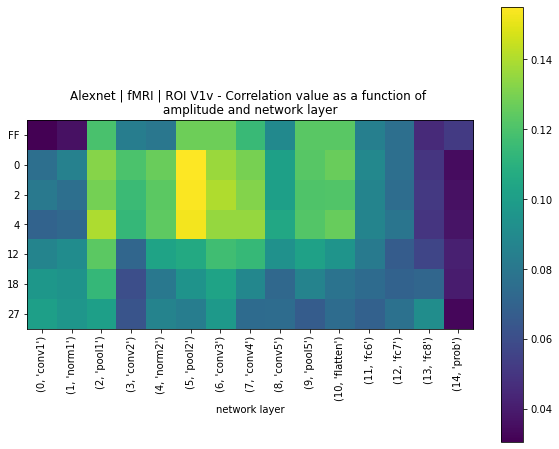

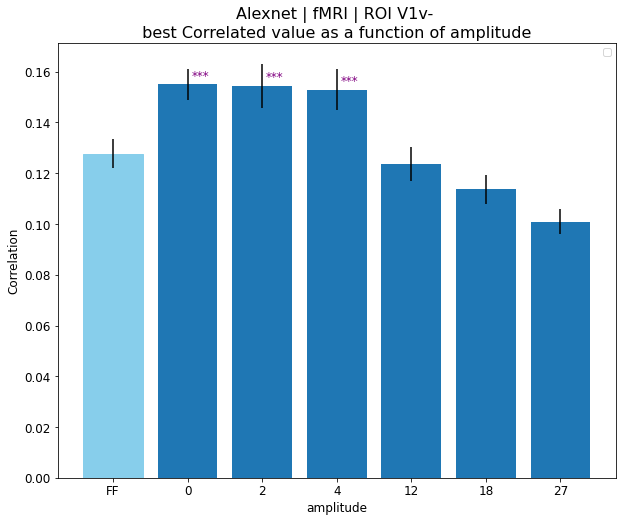

No handles with labels found to put in legend.


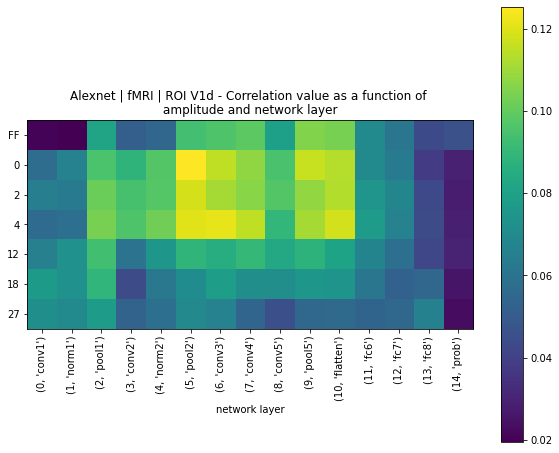

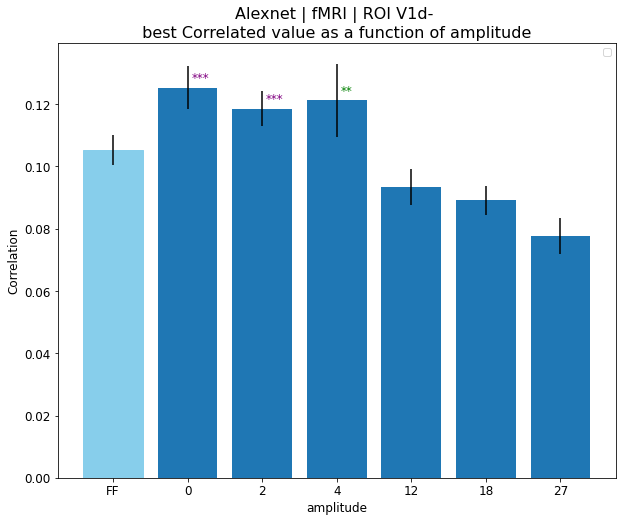

No handles with labels found to put in legend.


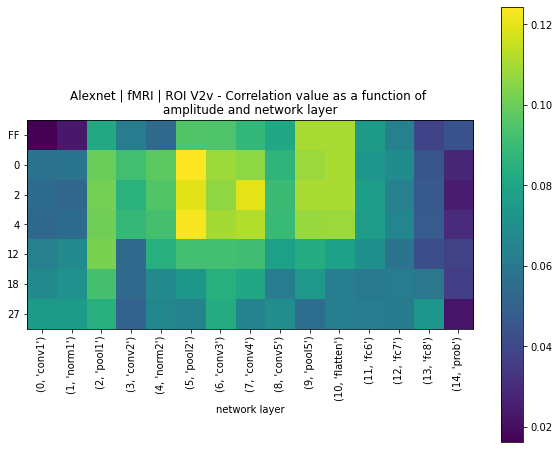

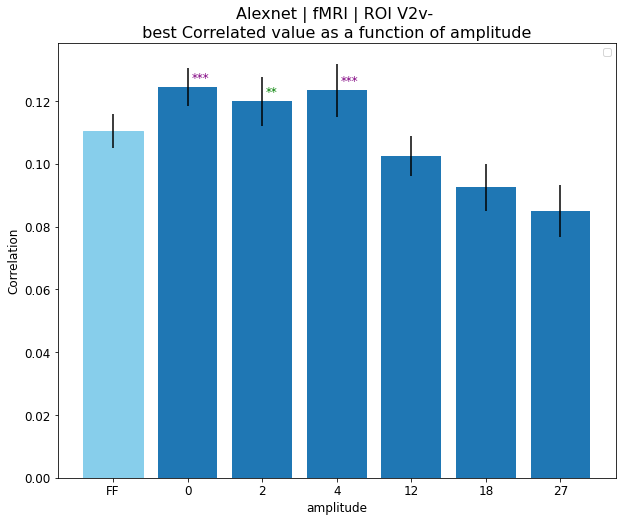

No handles with labels found to put in legend.


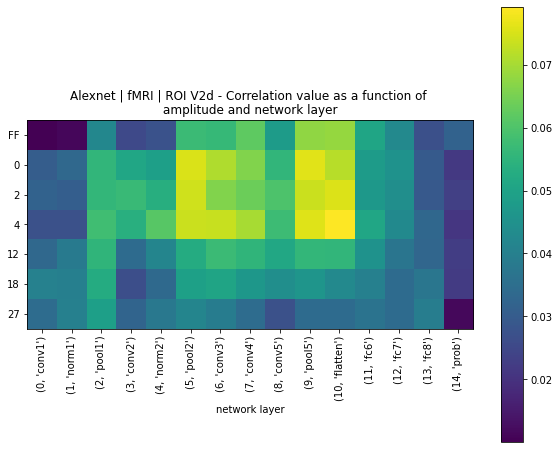

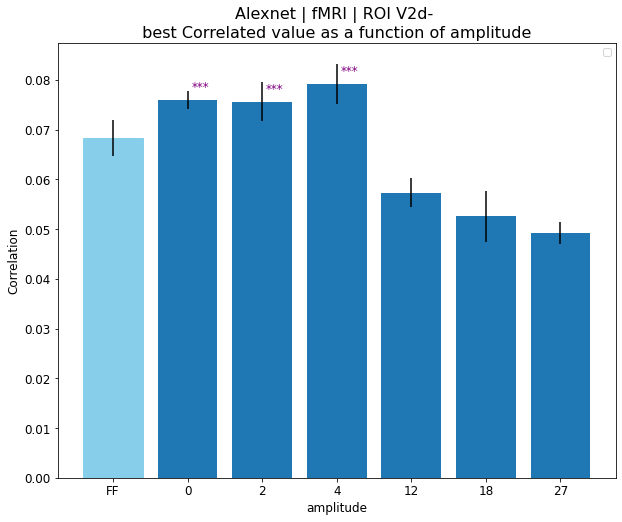

No handles with labels found to put in legend.


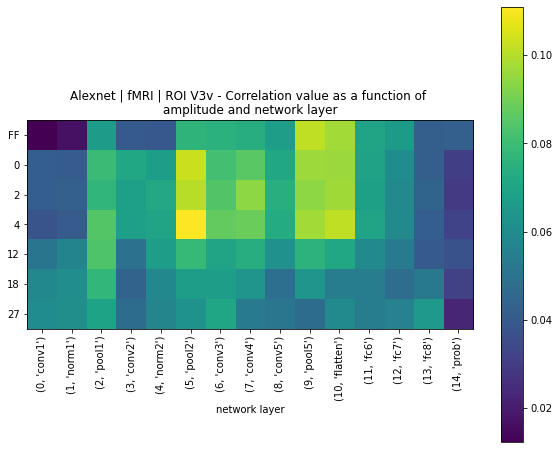

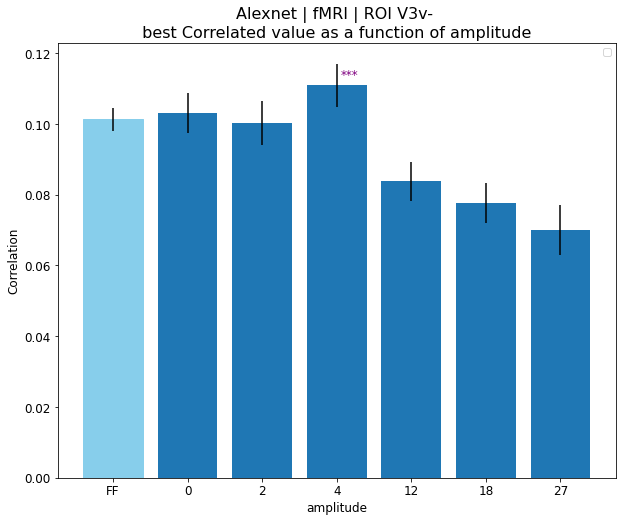

No handles with labels found to put in legend.


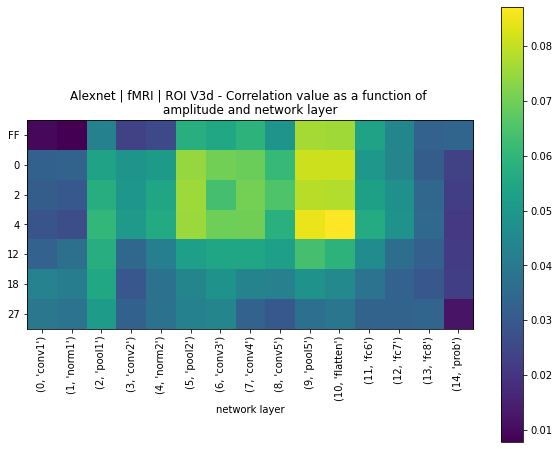

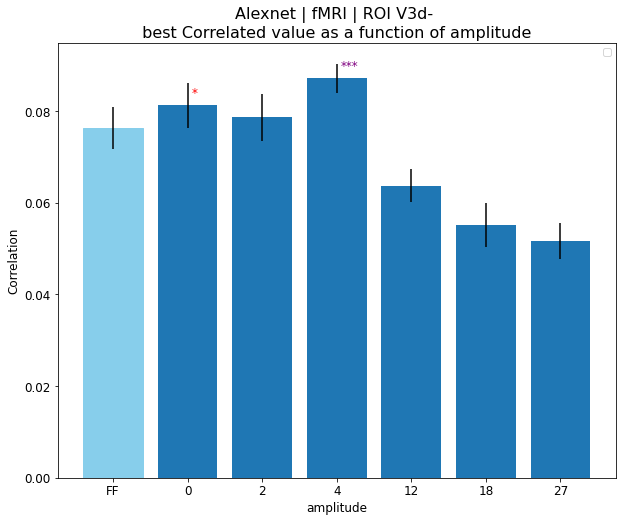

No handles with labels found to put in legend.


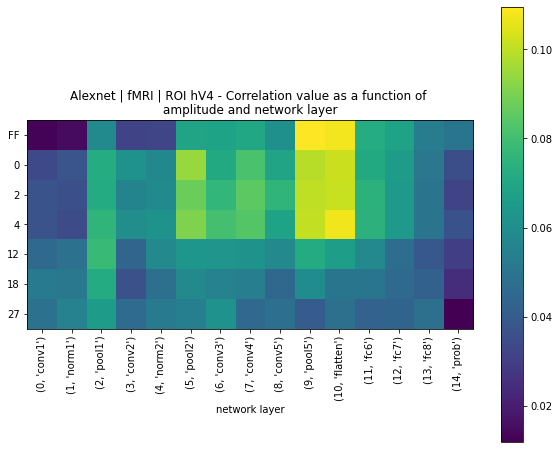

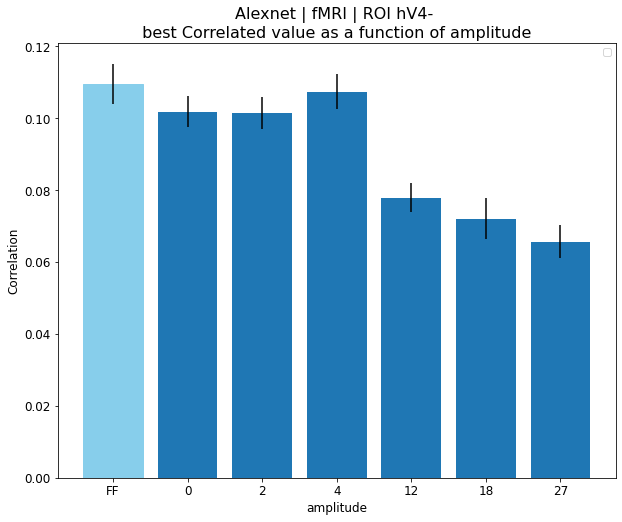

In [7]:
gap = 5
amplist = [str(amp) for amp in corr_dict_vis_all_drc_alex.keys()]
amplist.insert(0,'FF')
alpha = 0.05  # significance level
alpha_1 = 0.01

for key in corr_dict_vis_all_vgg_alex.keys():
    cor = np.zeros([len(list(corr_dict_vis_all_drc_alex.keys())) + 1, corr_dict_vis_all_vgg_alex[key].shape[1]])
    sd = np.zeros_like(cor)
    cor[0] = np.mean(corr_dict_vis_all_vgg_alex[key], axis=0)
    sd[0] = np.std(corr_dict_vis_all_vgg_alex[key], axis=0)
    for i, amp in enumerate(corr_dict_vis_all_drc_alex.keys()):
        cor[i+1] = np.mean(corr_dict_vis_all_drc_alex[amp][key][:,gap:], axis=0)
        sd[i+1] = np.std(corr_dict_vis_all_drc_alex[amp][key][:,gap:], axis=0)

    plt.figure(figsize=(10,8))
    plt.imshow(cor)
    plt.title("Alexnet | fMRI | ROI "+ key +" - Correlation value as a function of \n amplitude and network layer ")
    plt.yticks(np.arange(0,7), amplist)
    plt.xticks(range(corr_dict_vis_all_vgg_alex[key].shape[1]), [(i, l.name) for i,l in enumerate(model.layers)],rotation = 90)
    plt.xlabel('network layer')
    cbar = plt.colorbar(orientation='vertical')
    plt.savefig("/home/mor/NDS_project/results_data/sub2/General/Alexnet_image_ROI_"+ key, size=16)    
   
    plt.figure(figsize=(10,8))
    max_cor = np.max(cor, axis=1) # the maximum correlated layer for each network condition (FF+ all amps)
    max_cor_arg = [np.argmax(cor, axis=1)[i] for i in range(max_cor.shape[0])] # the *ARG*maximum correlated layer for each network condition (FF+ all amps)
    max_cor_sd = [sd[i,np.argmax(cor, axis=1)[i]] for i in range(sd.shape[0])] # the SD for each max correlated layer for each condition
    max_cor_ff = corr_dict_vis_all_vgg_alex[key][:,max_cor_arg[0]] # The correlation samples for the mex correlated layer for FF
    max_cor_amp = [corr_dict_vis_all_drc_alex[amp][key][:,max_cor_arg[i+1]+gap] for i,amp in enumerate(corr_dict_vis_all_drc_alex.keys())] # The correlation samples for the mex correlated layer for each amp
    pvalues = [one_side_t_test(max_cor_ff, max_cor_amp[i]) for i in range(len(max_cor_amp))]

    bars = plt.bar(np.arange(0,7), max_cor, yerr=max_cor_sd, zorder=1)
    x_coords = [bar.get_x() + bar.get_width() / 2 for bar in bars]
#     plt.scatter(x_coords, np.ones(len(x_coords)) * max_cor[0], c='r', zorder=2, label='FF correlation level') 
    
    for i in range(6):
        if pvalues[i] < alpha_1/10:
            plt.text(i+1.05, max_cor[i+1]+0.002, '***', c='purple', size=12)
        elif pvalues[i] < alpha_1:
            plt.text(i+1.05, max_cor[i+1]+0.002, '**', c='g', size=12)
        elif pvalues[i] < alpha:
            plt.text(i+1.05, max_cor[i+1]+0.002, '*', c='r', size=12)
        elif pvalues[i] < alpha*2:
            plt.text(i+1.05, max_cor[i+1]+0.002, '†', c='darkorange', size=12)
    bars[0].set_color('skyblue')
    plt.yticks(size=12)
    plt.xticks(np.arange(0,7), amplist, size=12)
    plt.xlabel('amplitude', size=12)
    plt.ylabel('Correlation', size=12)
    plt.title("Alexnet | fMRI | ROI "+ key +"- \n best Correlated value as a function of amplitude ", size=16)
    plt.legend()
    plt.savefig("/home/mor/NDS_project/results_data/sub2/General/Alexnet_bar_ROI_"+ key)    
    plt.show()

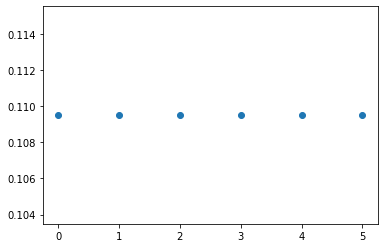

In [8]:
plt.scatter(np.arange(0,6), np.ones(6)*max_cor[0])

In [9]:
amplist = ['DRC amp ' + str(amp) for amp in corr_dict_vis_all_drc.keys()]
['FF'].extend(amplist)
amplist.insert(0,'FF')
amplist

['FF',
 'DRC amp 0',
 'DRC amp 2',
 'DRC amp 4',
 'DRC amp 12',
 'DRC amp 18',
 'DRC amp 27']

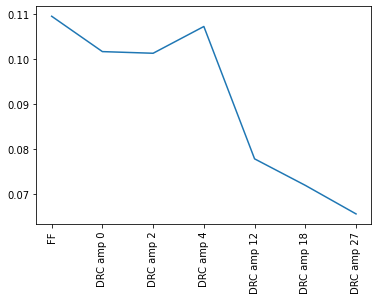

In [10]:
max_cor = np.max(cor, axis=1)
plt.plot(max_cor)
plt.xticks(np.arange(0,7), amplist,rotation = 90)
plt.show()

In [11]:
# T test
ttest(corr_dict_vis_all_vgg['V1'], corr_dict_vis_all_drc[0]['V1'])

KeyError: 'V1'

In [ ]:
corr_dict_vis_all_drc[0]['V1'].shape

In [ ]:
max_cor
max_cor_arg = [np.argmax(cor, axis=1)[i] for i in range(max_cor.shape[0])]
max_cor_amp = [corr_dict_vis_all_drc[key]['V2'][:,max_cor_arg[i]] for i,key in enumerate(corr_dict_vis_all_drc.keys())]
max_cor_ff = corr_dict_vis_all_vgg['V2'][:,max_cor_arg[0]]

In [ ]:
max_cor_amp

In [ ]:
a = [ttest(max_cor_ff, max_cor_amp[i]).pvalue for i in range(len(max_cor_amp))]
a